In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis

def extract_features(data):
    """Extract time and frequency domain features from a given signal."""
    if len(data) == 0:
        return np.zeros(16)  # Return a zero-filled array if data is empty
    
    # Time domain features
    time_domain_features = [
        np.max(data),                            # Max
        np.min(data),                            # Min
        np.mean(data),                           # Mean
        np.std(data),                            # Standard Deviation
        np.mean(np.abs(data - np.mean(data))),   # Mean deviation
        np.sqrt(np.mean(np.square(data))),       # Root mean square
        skew(data),                              # Skewness
        kurtosis(data)                           # Kurtosis
    ]

    # Frequency domain features
    row_fft = np.fft.fft(data)
    row_magnitude = np.abs(row_fft)

    frequency_domain_features = [
        np.sum(row_magnitude * np.arange(len(row_magnitude))) / np.sum(row_magnitude),  # Centroid
        -np.sum(row_magnitude * np.log2(row_magnitude + 1e-10)),                        # Entropy
        np.max(data) - np.min(data),                                                   # Spread
        skew(row_magnitude),                                                           # Skewness
        np.mean(row_magnitude),                                                        # Mean
        kurtosis(row_magnitude),                                                       # Kurtosis
        np.mean(np.abs(np.diff(data))),                                                # Irregularity
        np.var(row_magnitude)                                                          # Variance
    ]
    return time_domain_features + frequency_domain_features

# Load the Excel file into a Pandas DataFrame
file_path = "'C:\\Users\\awm21\\Desktop\\Data_Acq\\ADC_2\\Ch_2\\Graphs\\25_MSPS.xlsx"
csv2 = pd.read_excel(file_path, engine='openpyxl')

# Assume the first column contains the data
data = csv2.iloc[:, 0].to_numpy()

# Initialize lists to store high (positive) and low (negative) cycles
high_cycles = []
low_cycles = []

current_cycle = []  # To collect values in the current cycle
in_high_cycle = False  # Track whether we're in a high or low cycle

# Separate data into high and low cycles
for value in data:
    if value >= 0:  # High cycle
        if in_high_cycle or not current_cycle:
            current_cycle.append(value)
        else:  # Transition from low to high
            low_cycles.append(current_cycle)
            current_cycle = [value]
        in_high_cycle = True
    else:  # Low cycle
        if not in_high_cycle or not current_cycle:
            current_cycle.append(value)
        else:  # Transition from high to low
            high_cycles.append(current_cycle)
            current_cycle = [value]
        in_high_cycle = False

# Add the last remaining cycle
if current_cycle:
    if in_high_cycle:
        high_cycles.append(current_cycle)
    else:
        low_cycles.append(current_cycle)

# Trim the first and last cycles
high_cycles = high_cycles[1:-1] if len(high_cycles) > 2 else high_cycles
low_cycles = low_cycles[1:-1] if len(low_cycles) > 2 else low_cycles

# Ensure the number of high and low cycles is the same
if len(high_cycles) > len(low_cycles):
    high_cycles = high_cycles[:len(low_cycles)]
elif len(low_cycles) > len(high_cycles):
    low_cycles = low_cycles[:len(high_cycles)]

# Notify user to verify the cycle counts
print(f"Number of high cycles after trimming: {len(high_cycles)}")
print(f"Number of low cycles after trimming: {len(low_cycles)}")

# User prompt for confirmation
input("Please verify the above trimming. Press Enter to confirm and proceed with feature extraction...")

# Convert cycles to float arrays
high_cycles = [np.array(cycle, dtype=float) for cycle in high_cycles]
low_cycles = [np.array(cycle, dtype=float) for cycle in low_cycles]

# Pad the cycles with NaN to make them the same length
max_length = max(max(len(cycle) for cycle in high_cycles), max(len(cycle) for cycle in low_cycles))
high_cycles_padded = [np.pad(cycle, (0, max_length - len(cycle)), constant_values=np.nan) for cycle in high_cycles]
low_cycles_padded = [np.pad(cycle, (0, max_length - len(cycle)), constant_values=np.nan) for cycle in low_cycles]

# Convert to NumPy arrays
high_data = np.array(high_cycles_padded)
low_data = np.array(low_cycles_padded)

# Perform differentiation and integration row-wise
diff_high = np.diff(high_data, axis=1, prepend=high_data[:, 0:1])
diff_low = np.diff(low_data, axis=1, prepend=low_data[:, 0:1])
int_high = np.cumsum(high_data, axis=1)
int_low = np.cumsum(low_data, axis=1)

# Extract features
features_high = [extract_features(cycle[~np.isnan(cycle)]) for cycle in high_data]
features_low = [extract_features(cycle[~np.isnan(cycle)]) for cycle in low_data]
features_diff_high = [extract_features(cycle[~np.isnan(cycle)]) for cycle in diff_high]
features_diff_low = [extract_features(cycle[~np.isnan(cycle)]) for cycle in diff_low]
features_int_high = [extract_features(cycle[~np.isnan(cycle)]) for cycle in int_high]
features_int_low = [extract_features(cycle[~np.isnan(cycle)]) for cycle in int_low]

# Convert features to NumPy arrays
features_high_np = np.array(features_high)
features_low_np = np.array(features_low)
features_diff_high_np = np.array(features_diff_high)
features_diff_low_np = np.array(features_diff_low)
features_int_high_np = np.array(features_int_high)
features_int_low_np = np.array(features_int_low)

# Concatenate all feature arrays
features_dataset = np.concatenate((
    features_high_np,
    features_low_np,
    features_diff_high_np,
    features_diff_low_np,
    features_int_high_np,
    features_int_low_np
), axis=1)

# Specify the save path for the features dataset
save_path = "C:\\Users\\awm21\\Documents\\FPGA_Task\\Neural_Networks\\Features_Vitis"
os.makedirs(save_path, exist_ok=True)  # Ensure the directory exists

# Save the features dataset
csv_save_path = os.path.join(save_path, "fd_ADC2_Ch2_25MSPS.csv")
npy_save_path = os.path.join(save_path, "fd_ADC2_Ch2_25MSPS.npy")

np.savetxt(csv_save_path, features_dataset, delimiter=",")
np.save(npy_save_path, features_dataset, allow_pickle=True)

# Print summary
print(f"High cycle features shape: {features_high_np.shape}")
print(f"Low cycle features shape: {features_low_np.shape}")
print(f"Diff high cycle features shape: {features_diff_high_np.shape}")
print(f"Diff low cycle features shape: {features_diff_low_np.shape}")
print(f"Int high cycle features shape: {features_int_high_np.shape}")
print(f"Int low cycle features shape: {features_int_low_np.shape}")
print(f"Combined features dataset shape: {features_dataset.shape}")
print(f"Features saved to: {csv_save_path} and {npy_save_path}")


Number of high cycles after trimming: 39999
Number of low cycles after trimming: 39999
High cycle features shape: (39999, 16)
Low cycle features shape: (39999, 16)
Diff high cycle features shape: (39999, 16)
Diff low cycle features shape: (39999, 16)
Int high cycle features shape: (39999, 16)
Int low cycle features shape: (39999, 16)
Combined features dataset shape: (39999, 96)
Features saved to: C:\Users\awm21\Documents\FPGA_Task\Neural_Networks\Features\fd_ADC2_Ch2_1MSPS.csv and C:\Users\awm21\Documents\FPGA_Task\Neural_Networks\Features\fd_ADC2_Ch2_1MSPS.npy


In [8]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis

def extract_features(data):
    """Extract time and frequency domain features from a given signal."""
    if len(data) == 0:
        return np.zeros(16)  # Return a zero-filled array if data is empty
    
    # Time domain features
    time_domain_features = [
        np.max(data),                            # Max
        np.min(data),                            # Min
        np.mean(data),                           # Mean
        np.std(data),                            # Standard Deviation
        np.mean(np.abs(data - np.mean(data))),   # Mean deviation
        np.sqrt(np.mean(np.square(data))),       # Root mean square
        skew(data),                              # Skewness
        kurtosis(data)                           # Kurtosis
    ]

    # Frequency domain features
    row_fft = np.fft.fft(data)
    row_magnitude = np.abs(row_fft)

    frequency_domain_features = [
        np.sum(row_magnitude * np.arange(len(row_magnitude))) / np.sum(row_magnitude),  # Centroid
        -np.sum(row_magnitude * np.log2(row_magnitude + 1e-10)),                        # Entropy
        np.max(data) - np.min(data),                                                   # Spread
        skew(row_magnitude),                                                           # Skewness
        np.mean(row_magnitude),                                                        # Mean
        kurtosis(row_magnitude),                                                       # Kurtosis
        np.mean(np.abs(np.diff(data))),                                                # Irregularity
        np.var(row_magnitude)                                                          # Variance
    ]
    return time_domain_features + frequency_domain_features

# Load the Excel file into a Pandas DataFrame
file_path = "C:\\Users\\awm21\\Desktop\\Data_Acq\\ADC_1\\Ch_1\\10_MSPS.xlsx"
csv2 = pd.read_excel(file_path, engine='openpyxl')

# Assume the first column contains the data
data = csv2.iloc[:, 0].to_numpy()

# Initialize lists to store high (positive) and low (negative) cycles
high_cycles = []
low_cycles = []

current_cycle = []  # To collect values in the current cycle
in_high_cycle = False  # Track whether we're in a high or low cycle

# Separate data into high and low cycles
for value in data:
    if value >= 0:  # High cycle
        if in_high_cycle or not current_cycle:
            current_cycle.append(value)
        else:  # Transition from low to high
            low_cycles.append(current_cycle)
            current_cycle = [value]
        in_high_cycle = True
    else:  # Low cycle
        if not in_high_cycle or not current_cycle:
            current_cycle.append(value)
        else:  # Transition from high to low
            high_cycles.append(current_cycle)
            current_cycle = [value]
        in_high_cycle = False

# Add the last remaining cycle
if current_cycle:
    if in_high_cycle:
        high_cycles.append(current_cycle)
    else:
        low_cycles.append(current_cycle)

# Trim the first and last cycles with 10x reduction
high_cycles = high_cycles[max(1, len(high_cycles) // 10):-max(1, len(high_cycles) // 10)] if len(high_cycles) > 2 else high_cycles
low_cycles = low_cycles[max(1, len(low_cycles) // 10):-max(1, len(low_cycles) // 10)] if len(low_cycles) > 2 else low_cycles

# Ensure the number of high and low cycles is the same
if len(high_cycles) > len(low_cycles):
    high_cycles = high_cycles[:len(low_cycles)]
elif len(low_cycles) > len(high_cycles):
    low_cycles = low_cycles[:len(high_cycles)]

# Notify user to verify the cycle counts
print(f"Number of high cycles after trimming: {len(high_cycles)}")
print(f"Number of low cycles after trimming: {len(low_cycles)}")

# User prompt for confirmation
input("Please verify the above trimming. Press Enter to confirm and proceed with feature extraction...")

# Convert cycles to float arrays
high_cycles = [np.array(cycle, dtype=float) for cycle in high_cycles]
low_cycles = [np.array(cycle, dtype=float) for cycle in low_cycles]

# Pad the cycles with NaN to make them the same length
max_length = max(max(len(cycle) for cycle in high_cycles), max(len(cycle) for cycle in low_cycles))
high_cycles_padded = [np.pad(cycle, (0, max_length - len(cycle)), constant_values=np.nan) for cycle in high_cycles]
low_cycles_padded = [np.pad(cycle, (0, max_length - len(cycle)), constant_values=np.nan) for cycle in low_cycles]

# Convert to NumPy arrays
high_data = np.array(high_cycles_padded)
low_data = np.array(low_cycles_padded)

# Perform differentiation and integration row-wise
diff_high = np.diff(high_data, axis=1, prepend=high_data[:, 0:1])
diff_low = np.diff(low_data, axis=1, prepend=low_data[:, 0:1])
int_high = np.cumsum(high_data, axis=1)
int_low = np.cumsum(low_data, axis=1)

# Extract features
features_high = [extract_features(cycle[~np.isnan(cycle)]) for cycle in high_data]
features_low = [extract_features(cycle[~np.isnan(cycle)]) for cycle in low_data]
features_diff_high = [extract_features(cycle[~np.isnan(cycle)]) for cycle in diff_high]
features_diff_low = [extract_features(cycle[~np.isnan(cycle)]) for cycle in diff_low]
features_int_high = [extract_features(cycle[~np.isnan(cycle)]) for cycle in int_high]
features_int_low = [extract_features(cycle[~np.isnan(cycle)]) for cycle in int_low]

# Convert features to NumPy arrays
features_high_np = np.array(features_high)
features_low_np = np.array(features_low)
features_diff_high_np = np.array(features_diff_high)
features_diff_low_np = np.array(features_diff_low)
features_int_high_np = np.array(features_int_high)
features_int_low_np = np.array(features_int_low)

# Concatenate all feature arrays
features_dataset = np.concatenate((
    features_high_np,
    features_low_np,
    features_diff_high_np,
    features_diff_low_np,
    features_int_high_np,
    features_int_low_np
), axis=1)

# Specify the save path for the features dataset
save_path = "C:\\Users\\awm21\\Documents\\FPGA_Task\\Neural_Networks\\Features_Vitis"
os.makedirs(save_path, exist_ok=True)  # Ensure the directory exists

# Save the features dataset
csv_save_path = os.path.join(save_path, "fd_ADC1_Ch1_10MSPS.csv")
npy_save_path = os.path.join(save_path, "fd_ADC1_Ch1_10MSPS.npy")

np.savetxt(csv_save_path, features_dataset, delimiter=",")
np.save(npy_save_path, features_dataset, allow_pickle=True)

# Print summary
print(f"High cycle features shape: {features_high_np.shape}")
print(f"Low cycle features shape: {features_low_np.shape}")
print(f"Diff high cycle features shape: {features_diff_high_np.shape}")
print(f"Diff low cycle features shape: {features_diff_low_np.shape}")
print(f"Int high cycle features shape: {features_int_high_np.shape}")
print(f"Int low cycle features shape: {features_int_low_np.shape}")
print(f"Combined features dataset shape: {features_dataset.shape}")
print(f"Features saved to: {csv_save_path} and {npy_save_path}")


Number of high cycles after trimming: 7812
Number of low cycles after trimming: 7812
High cycle features shape: (7812, 16)
Low cycle features shape: (7812, 16)
Diff high cycle features shape: (7812, 16)
Diff low cycle features shape: (7812, 16)
Int high cycle features shape: (7812, 16)
Int low cycle features shape: (7812, 16)
Combined features dataset shape: (7812, 96)
Features saved to: C:\Users\awm21\Documents\FPGA_Task\Neural_Networks\Features_Vitis\fd_ADC1_Ch1_10MSPS.csv and C:\Users\awm21\Documents\FPGA_Task\Neural_Networks\Features_Vitis\fd_ADC1_Ch1_10MSPS.npy


# New

In [1]:
import os
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis

def extract_features(data):
    """Extract time and frequency domain features from a given signal."""
    if len(data) == 0:
        return np.zeros(16)
    
    # Time domain features
    time_domain_features = [
        np.max(data),
        np.min(data),
        np.mean(data),
        np.std(data),
        np.mean(np.abs(data - np.mean(data))),
        np.sqrt(np.mean(np.square(data))),
        skew(data),
        kurtosis(data)
    ]

    # Frequency domain features
    row_fft = np.fft.fft(data)
    row_magnitude = np.abs(row_fft)
    frequency_domain_features = [
        np.sum(row_magnitude * np.arange(len(row_magnitude))) / np.sum(row_magnitude),
        -np.sum(row_magnitude * np.log2(row_magnitude + 1e-10)),
        np.max(data) - np.min(data),
        skew(row_magnitude),
        np.mean(row_magnitude),
        kurtosis(row_magnitude),
        np.mean(np.abs(np.diff(data))),
        np.var(row_magnitude)
    ]
    return time_domain_features + frequency_domain_features

def process_data(file_path):
    """Process the data from a CSV file and extract features."""
    csv_data = pd.read_csv(file_path)
    data = csv_data.iloc[:, 0].to_numpy()

    # Split into high and low cycles
    high_cycles, low_cycles, current_cycle = [], [], []
    in_high_cycle = False

    for value in data:
        if value >= 0:
            if in_high_cycle or not current_cycle:
                current_cycle.append(value)
            else:
                low_cycles.append(current_cycle)
                current_cycle = [value]
            in_high_cycle = True
        else:
            if not in_high_cycle or not current_cycle:
                current_cycle.append(value)
            else:
                high_cycles.append(current_cycle)
                current_cycle = [value]
            in_high_cycle = False

    if current_cycle:
        if in_high_cycle:
            high_cycles.append(current_cycle)
        else:
            low_cycles.append(current_cycle)

    # Trim cycles
    high_cycles = high_cycles[max(1, len(high_cycles) // 10):-max(1, len(high_cycles) // 10)] if len(high_cycles) > 2 else high_cycles
    low_cycles = low_cycles[max(1, len(low_cycles) // 10):-max(1, len(low_cycles) // 10)] if len(low_cycles) > 2 else low_cycles

    # Ensure the same number of cycles
    min_cycles = min(len(high_cycles), len(low_cycles))
    high_cycles, low_cycles = high_cycles[:min_cycles], low_cycles[:min_cycles]

    # Convert to numpy arrays and extract features
    high_cycles_np = [np.array(cycle, dtype=float) for cycle in high_cycles]
    low_cycles_np = [np.array(cycle, dtype=float) for cycle in low_cycles]

    features_high = [extract_features(cycle) for cycle in high_cycles_np]
    features_low = [extract_features(cycle) for cycle in low_cycles_np]

    return np.array(features_high), np.array(features_low)

def process_all_data(base_dir, sampling_rates, adc_channels, save_dir):
    """Process all ADCs, channels, and sampling rates and save the features."""
    os.makedirs(save_dir, exist_ok=True)
    
    for adc, channel in adc_channels:
        for rate in sampling_rates:
            folder_path = os.path.join(base_dir, adc, channel)
            file_name = f"{rate}_MSPS.csv"
            file_path = os.path.join(folder_path, file_name)
            
            if os.path.exists(file_path):
                print(f"Processing: {file_path}")
                features_high, features_low = process_data(file_path)

                # Combine and save features
                features_dataset = np.concatenate((features_high, features_low), axis=0)
                csv_save_path = os.path.join(save_dir, f"fd_{adc}_{channel}_{rate}MSPS.csv")
                npy_save_path = os.path.join(save_dir, f"fd_{adc}_{channel}_{rate}MSPS.npy")

                np.savetxt(csv_save_path, features_dataset, delimiter=",")
                np.save(npy_save_path, features_dataset)
                
                print(f"Features saved to: {csv_save_path} and {npy_save_path}")
            else:
                print(f"File not found: {file_path}")

# Define parameters
base_dir = "C:\\Users\\awm21\\Desktop\\Data_Acq"
save_dir = "C:\\Users\\awm21\\Documents\\FPGA_Task\\Neural_Networks\\Features_Vitis"
sampling_rates = [7, 10, 15, 20, 25, 30, 35, 40, 50, 58, 72, 81, 93, 108, 130, 162, 216]
adc_channels = [#("ADC_1", "Ch_1"),
                 #("ADC_1", "Ch_2")]
                 #("ADC_2", "Ch_1")]
                ("ADC_2", "Ch_2")]

# Process all data
process_all_data(base_dir, sampling_rates, adc_channels, save_dir)


Processing: C:\Users\awm21\Desktop\Data_Acq\ADC_2\Ch_2\7_MSPS.csv
Features saved to: C:\Users\awm21\Documents\FPGA_Task\Neural_Networks\Features_Vitis\fd_ADC_2_Ch_2_7MSPS.csv and C:\Users\awm21\Documents\FPGA_Task\Neural_Networks\Features_Vitis\fd_ADC_2_Ch_2_7MSPS.npy
Processing: C:\Users\awm21\Desktop\Data_Acq\ADC_2\Ch_2\10_MSPS.csv
Features saved to: C:\Users\awm21\Documents\FPGA_Task\Neural_Networks\Features_Vitis\fd_ADC_2_Ch_2_10MSPS.csv and C:\Users\awm21\Documents\FPGA_Task\Neural_Networks\Features_Vitis\fd_ADC_2_Ch_2_10MSPS.npy
Processing: C:\Users\awm21\Desktop\Data_Acq\ADC_2\Ch_2\15_MSPS.csv
Features saved to: C:\Users\awm21\Documents\FPGA_Task\Neural_Networks\Features_Vitis\fd_ADC_2_Ch_2_15MSPS.csv and C:\Users\awm21\Documents\FPGA_Task\Neural_Networks\Features_Vitis\fd_ADC_2_Ch_2_15MSPS.npy
Processing: C:\Users\awm21\Desktop\Data_Acq\ADC_2\Ch_2\20_MSPS.csv
Features saved to: C:\Users\awm21\Documents\FPGA_Task\Neural_Networks\Features_Vitis\fd_ADC_2_Ch_2_20MSPS.csv and C:\Use

In [9]:
import os
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis

def extract_features(data):
    """Extract time and frequency domain features from a given signal."""
    if len(data) == 0:
        return np.zeros(16)
    
    # Time domain features
    time_domain_features = [
        np.max(data),
        np.min(data),
        np.mean(data),
        np.std(data),
        np.mean(np.abs(data - np.mean(data))),
        np.sqrt(np.mean(np.square(data))),
        skew(data),
        kurtosis(data)
    ]

    # Frequency domain features
    row_fft = np.fft.fft(data)
    row_magnitude = np.abs(row_fft)
    frequency_domain_features = [
        np.sum(row_magnitude * np.arange(len(row_magnitude))) / np.sum(row_magnitude),
        -np.sum(row_magnitude * np.log2(row_magnitude + 1e-10)),
        np.max(data) - np.min(data),
        skew(row_magnitude),
        np.mean(row_magnitude),
        kurtosis(row_magnitude),
        np.mean(np.abs(np.diff(data))),
        np.var(row_magnitude)
    ]
    return time_domain_features + frequency_domain_features

def process_data(file_path):
    """Process the data from a CSV file and extract features."""
    csv_data = pd.read_csv(file_path)
    data = csv_data.iloc[:, 0].to_numpy()

    # Split into high and low cycles
    high_cycles, low_cycles, current_cycle = [], [], []
    in_high_cycle = False

    for value in data:
        if value >= 0:
            if in_high_cycle or not current_cycle:
                current_cycle.append(value)
            else:
                low_cycles.append(current_cycle)
                current_cycle = [value]
            in_high_cycle = True
        else:
            if not in_high_cycle or not current_cycle:
                current_cycle.append(value)
            else:
                high_cycles.append(current_cycle)
                current_cycle = [value]
            in_high_cycle = False

    if current_cycle:
        if in_high_cycle:
            high_cycles.append(current_cycle)
        else:
            low_cycles.append(current_cycle)

    # Trim cycles
    high_cycles = high_cycles[max(1, len(high_cycles) // 10):-max(1, len(high_cycles) // 10)] if len(high_cycles) > 2 else high_cycles
    low_cycles = low_cycles[max(1, len(low_cycles) // 10):-max(1, len(low_cycles) // 10)] if len(low_cycles) > 2 else low_cycles

    # Ensure the same number of cycles
    min_cycles = min(len(high_cycles), len(low_cycles))
    high_cycles, low_cycles = high_cycles[:min_cycles], low_cycles[:min_cycles]

    # Convert to numpy arrays and extract features
    high_cycles_np = [np.array(cycle, dtype=float) for cycle in high_cycles]
    low_cycles_np = [np.array(cycle, dtype=float) for cycle in low_cycles]

    features_high = [extract_features(cycle) for cycle in high_cycles_np]
    features_low = [extract_features(cycle) for cycle in low_cycles_np]

    return np.array(features_high), np.array(features_low)

def process_all_data(base_dir, sampling_rates, adc_channels, save_dir):
    """Process all ADCs, channels, and sampling rates and save the features."""
    os.makedirs(save_dir, exist_ok=True)
    
    for adc, channel in adc_channels:
        for rate in sampling_rates:
            folder_path = os.path.join(base_dir, adc, channel)
            file_name = f"{rate}_MSPS.csv"
            file_path = os.path.join(folder_path, file_name)
            
            if os.path.exists(file_path):
                print(f"Processing: {file_path}")
                features_high, features_low = process_data(file_path)

                # Combine and save features
                features_dataset = np.concatenate((features_high, features_low), axis=0)
                csv_save_path = os.path.join(save_dir, f"fd_{adc}_{channel}_{rate}MSPS.csv")
                npy_save_path = os.path.join(save_dir, f"fd_{adc}_{channel}_{rate}MSPS.npy")

                np.savetxt(csv_save_path, features_dataset, delimiter=",")
                np.save(npy_save_path, features_dataset)
                
                print(f"Features saved to: {csv_save_path} and {npy_save_path}")
            else:
                print(f"File not found: {file_path}")

# Define parameters
base_dir = "C:\\Users\\awm21\\Desktop\\Data_Acq"
save_dir = "C:\\Users\\awm21\\Documents\\FPGA_Task\\Neural_Networks\\Features_Vitis"
sampling_rates = [7, 10, 15, 20, 25, 30, 35, 40]
adc_channels = [("ADC1", "Ch1"), ("ADC1", "Ch2"), ("ADC2", "Ch1"), ("ADC2", "Ch2")]

# Process all data
process_all_data(base_dir, sampling_rates, adc_channels, save_dir)


File not found: C:\Users\awm21\Desktop\Data_Acq\ADC1\Ch1\7_MSPS.csv
File not found: C:\Users\awm21\Desktop\Data_Acq\ADC1\Ch1\10_MSPS.csv
File not found: C:\Users\awm21\Desktop\Data_Acq\ADC1\Ch1\15_MSPS.csv
File not found: C:\Users\awm21\Desktop\Data_Acq\ADC1\Ch1\20_MSPS.csv
File not found: C:\Users\awm21\Desktop\Data_Acq\ADC1\Ch1\25_MSPS.csv
File not found: C:\Users\awm21\Desktop\Data_Acq\ADC1\Ch1\30_MSPS.csv
File not found: C:\Users\awm21\Desktop\Data_Acq\ADC1\Ch1\35_MSPS.csv
File not found: C:\Users\awm21\Desktop\Data_Acq\ADC1\Ch1\40_MSPS.csv
File not found: C:\Users\awm21\Desktop\Data_Acq\ADC1\Ch2\7_MSPS.csv
File not found: C:\Users\awm21\Desktop\Data_Acq\ADC1\Ch2\10_MSPS.csv
File not found: C:\Users\awm21\Desktop\Data_Acq\ADC1\Ch2\15_MSPS.csv
File not found: C:\Users\awm21\Desktop\Data_Acq\ADC1\Ch2\20_MSPS.csv
File not found: C:\Users\awm21\Desktop\Data_Acq\ADC1\Ch2\25_MSPS.csv
File not found: C:\Users\awm21\Desktop\Data_Acq\ADC1\Ch2\30_MSPS.csv
File not found: C:\Users\awm21\Deskt

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis

def extract_features(data):
    """Extract time and frequency domain features from a given signal."""
    if len(data) == 0:
        return np.zeros(16)  # Return a zero-filled array if data is empty
    
    # Time domain features
    time_domain_features = [
        np.max(data),                            # Max
        np.min(data),                            # Min
        np.mean(data),                           # Mean
        np.std(data),                            # Standard Deviation
        np.mean(np.abs(data - np.mean(data))),   # Mean deviation
        np.sqrt(np.mean(np.square(data))),       # Root mean square
        skew(data),                              # Skewness
        kurtosis(data)                           # Kurtosis
    ]

    # Frequency domain features
    row_fft = np.fft.fft(data)
    row_magnitude = np.abs(row_fft)

    frequency_domain_features = [
        np.sum(row_magnitude * np.arange(len(row_magnitude))) / np.sum(row_magnitude),  # Centroid
        -np.sum(row_magnitude * np.log2(row_magnitude + 1e-10)),                        # Entropy
        np.max(data) - np.min(data),                                                   # Spread
        skew(row_magnitude),                                                           # Skewness
        np.mean(row_magnitude),                                                        # Mean
        kurtosis(row_magnitude),                                                       # Kurtosis
        np.mean(np.abs(np.diff(data))),                                                # Irregularity
        np.var(row_magnitude)                                                          # Variance
    ]
    return time_domain_features + frequency_domain_features

## Path to the CSV file
file_path = "C:\\Users\\awm21\\Documents\\Probe_Vari\\Datasets\\Probe1\\ADC1_CH1\\10_MSPS.csv"

# Read the CSV file without headers
csv_data = pd.read_csv(file_path, header=None)

# Assume the first column contains the data
data = csv_data.iloc[:, 0].to_numpy()

# Initialize lists to store high (positive) and low (negative) cycles
high_cycles = []
low_cycles = []

current_cycle = []  # To collect values in the current cycle
in_high_cycle = False  # Track whether we're in a high or low cycle

# Separate data into high and low cycles
for value in data:
    if value >= 0:  # High cycle
        if in_high_cycle or not current_cycle:
            current_cycle.append(value)
        else:  # Transition from low to high
            low_cycles.append(current_cycle)
            current_cycle = [value]
        in_high_cycle = True
    else:  # Low cycle
        if not in_high_cycle or not current_cycle:
            current_cycle.append(value)
        else:  # Transition from high to low
            high_cycles.append(current_cycle)
            current_cycle = [value]
        in_high_cycle = False

# Add the last remaining cycle
if current_cycle:
    if in_high_cycle:
        high_cycles.append(current_cycle)
    else:
        low_cycles.append(current_cycle)

# Trim the first and last cycles
high_cycles = high_cycles[1:-1] if len(high_cycles) > 2 else high_cycles
low_cycles = low_cycles[1:-1] if len(low_cycles) > 2 else low_cycles

# Ensure the number of high and low cycles is the same
if len(high_cycles) > len(low_cycles):
    high_cycles = high_cycles[:len(low_cycles)]
elif len(low_cycles) > len(high_cycles):
    low_cycles = low_cycles[:len(high_cycles)]

# Notify user to verify the cycle counts
print(f"Number of high cycles after trimming: {len(high_cycles)}")
print(f"Number of low cycles after trimming: {len(low_cycles)}")

# User prompt for confirmation
input("Please verify the above trimming. Press Enter to confirm and proceed with feature extraction...")

# Convert cycles to float arrays
high_cycles = [np.array(cycle, dtype=float) for cycle in high_cycles]
low_cycles = [np.array(cycle, dtype=float) for cycle in low_cycles]

# Pad the cycles with NaN to make them the same length
max_length = max(max(len(cycle) for cycle in high_cycles), max(len(cycle) for cycle in low_cycles))
high_cycles_padded = [np.pad(cycle, (0, max_length - len(cycle)), constant_values=np.nan) for cycle in high_cycles]
low_cycles_padded = [np.pad(cycle, (0, max_length - len(cycle)), constant_values=np.nan) for cycle in low_cycles]

# Convert to NumPy arrays
high_data = np.array(high_cycles_padded)
low_data = np.array(low_cycles_padded)

# Extract features
features_high = [extract_features(cycle[~np.isnan(cycle)]) for cycle in high_data]
features_low = [extract_features(cycle[~np.isnan(cycle)]) for cycle in low_data]

# Convert features to NumPy arrays
features_high_np = np.array(features_high)
features_low_np = np.array(features_low)

# Concatenate all feature arrays
features_dataset = np.concatenate((
    features_high_np,
    features_low_np
), axis=1)

# Specify the save path for the features dataset
save_path = "C:\\Users\\awm21\\Documents\\FPGA_Task\\Neural_Networks\\Features_Vitis\\Test"
os.makedirs(save_path, exist_ok=True)  # Ensure the directory exists

# Save the features dataset
csv_save_path = os.path.join(save_path, "fd_ADC2_Ch2_10_MSPS.csv")
npy_save_path = os.path.join(save_path, "fd_ADC2_Ch2_10_MSPS.npy")

np.savetxt(csv_save_path, features_dataset, delimiter=",")
np.save(npy_save_path, features_dataset, allow_pickle=True)

# Print summary
print(f"High cycle features shape: {features_high_np.shape}")
print(f"Low cycle features shape: {features_low_np.shape}")
print(f"Combined features dataset shape: {features_dataset.shape}")
print(f"Features saved to: {csv_save_path} and {npy_save_path}")

Number of high cycles after trimming: 9998
Number of low cycles after trimming: 9998
High cycle features shape: (9998, 16)
Low cycle features shape: (9998, 16)
Combined features dataset shape: (9998, 32)
Features saved to: C:\Users\awm21\Documents\FPGA_Task\Neural_Networks\Features_Vitis\Test\fd_ADC2_Ch2_10_MSPS.csv and C:\Users\awm21\Documents\FPGA_Task\Neural_Networks\Features_Vitis\Test\fd_ADC2_Ch2_10_MSPS.npy


Number of high cycles after trimming: 9998
Number of low cycles after trimming: 9998
High cycle features shape: (9998, 16)
Low cycle features shape: (9998, 16)
Combined features dataset shape: (9998, 32)
Features saved to: C:\Users\awm21\Documents\FPGA_Task\Neural_Networks\Features_Vitis\Test\fd_ADC2_Ch2_10_MSPS.csv and C:\Users\awm21\Documents\FPGA_Task\Neural_Networks\Features_Vitis\Test\fd_ADC2_Ch2_10_MSPS.npy


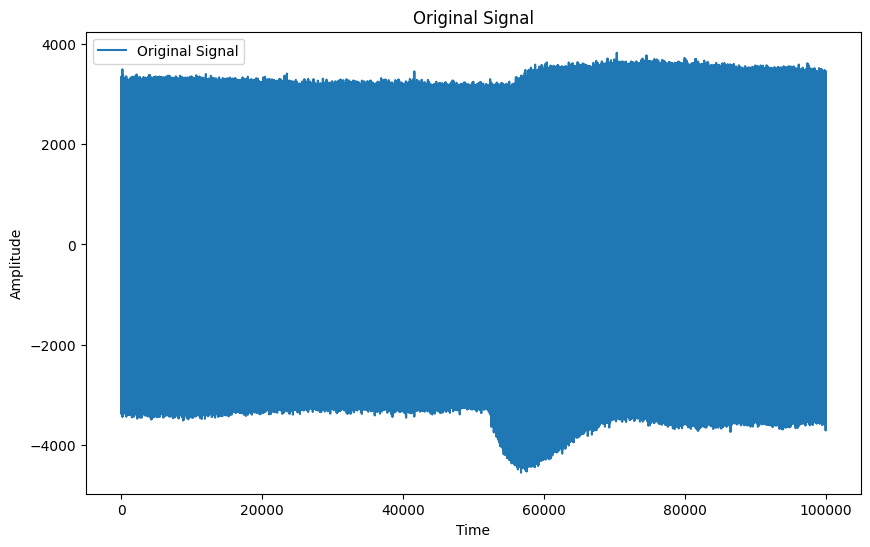

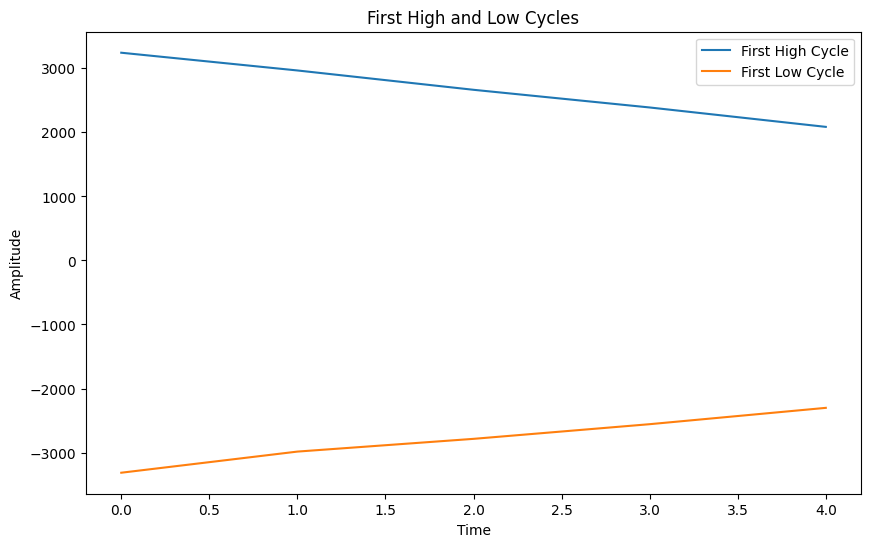

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis

def extract_features(data):
    """Extract time and frequency domain features from a given signal."""
    if len(data) == 0:
        return np.zeros(16)  # Return a zero-filled array if data is empty
    
    # Time domain features
    time_domain_features = [
        np.max(data),                            # Max
        np.min(data),                            # Min
        np.mean(data),                           # Mean
        np.std(data),                            # Standard Deviation
        np.mean(np.abs(data - np.mean(data))),   # Mean deviation
        np.sqrt(np.mean(np.square(data))),       # Root mean square
        skew(data),                              # Skewness
        kurtosis(data)                           # Kurtosis
    ]

    # Frequency domain features
    row_fft = np.fft.fft(data)
    row_magnitude = np.abs(row_fft)

    frequency_domain_features = [
        np.sum(row_magnitude * np.arange(len(row_magnitude))) / np.sum(row_magnitude),  # Centroid
        -np.sum(row_magnitude * np.log2(row_magnitude + 1e-10)),                        # Entropy
        np.max(data) - np.min(data),                                                   # Spread
        skew(row_magnitude),                                                           # Skewness
        np.mean(row_magnitude),                                                        # Mean
        kurtosis(row_magnitude),                                                       # Kurtosis
        np.mean(np.abs(np.diff(data))),                                                # Irregularity
        np.var(row_magnitude)                                                          # Variance
    ]
    return time_domain_features + frequency_domain_features

# Load the Excel file into a Pandas DataFrame
# Path to the CSV file
file_path = "C:\\Users\\awm21\\Documents\\Probe_Vari\\Datasets\\Probe1\\ADC1_CH1\\10_MSPS.csv"

# Read the CSV file without headers
csv_data = pd.read_csv(file_path, header=None)

# Assume the first column contains the data
data = csv_data.iloc[:, 0].to_numpy()
# Initialize lists to store high (positive) and low (negative) cycles
high_cycles = []
low_cycles = []

current_cycle = []  # To collect values in the current cycle
in_high_cycle = False  # Track whether we're in a high or low cycle

# Separate data into high and low cycles
for value in data:
    if value >= 0:  # High cycle
        if in_high_cycle or not current_cycle:
            current_cycle.append(value)
        else:  # Transition from low to high
            low_cycles.append(current_cycle)
            current_cycle = [value]
        in_high_cycle = True
    else:  # Low cycle
        if not in_high_cycle or not current_cycle:
            current_cycle.append(value)
        else:  # Transition from high to low
            high_cycles.append(current_cycle)
            current_cycle = [value]
        in_high_cycle = False

# Add the last remaining cycle
if current_cycle:
    if in_high_cycle:
        high_cycles.append(current_cycle)
    else:
        low_cycles.append(current_cycle)

# Trim the first and last cycles
high_cycles = high_cycles[1:-1] if len(high_cycles) > 2 else high_cycles
low_cycles = low_cycles[1:-1] if len(low_cycles) > 2 else low_cycles

# Ensure the number of high and low cycles is the same
if len(high_cycles) > len(low_cycles):
    high_cycles = high_cycles[:len(low_cycles)]
elif len(low_cycles) > len(high_cycles):
    low_cycles = low_cycles[:len(high_cycles)]

# Notify user to verify the cycle counts
print(f"Number of high cycles after trimming: {len(high_cycles)}")
print(f"Number of low cycles after trimming: {len(low_cycles)}")

# User prompt for confirmation
input("Please verify the above trimming. Press Enter to confirm and proceed with feature extraction...")

# Convert cycles to float arrays
high_cycles = [np.array(cycle, dtype=float) for cycle in high_cycles]
low_cycles = [np.array(cycle, dtype=float) for cycle in low_cycles]

# Pad the cycles with NaN to make them the same length
max_length = max(max(len(cycle) for cycle in high_cycles), max(len(cycle) for cycle in low_cycles))
high_cycles_padded = [np.pad(cycle, (0, max_length - len(cycle)), constant_values=np.nan) for cycle in high_cycles]
low_cycles_padded = [np.pad(cycle, (0, max_length - len(cycle)), constant_values=np.nan) for cycle in low_cycles]

# Convert to NumPy arrays
high_data = np.array(high_cycles_padded)
low_data = np.array(low_cycles_padded)

# Extract features
features_high = [extract_features(cycle[~np.isnan(cycle)]) for cycle in high_data]
features_low = [extract_features(cycle[~np.isnan(cycle)]) for cycle in low_data]

# Convert features to NumPy arrays
features_high_np = np.array(features_high)
features_low_np = np.array(features_low)

# Concatenate all feature arrays
features_dataset = np.concatenate((
    features_high_np,
    features_low_np
), axis=1)

# Specify the save path for the features dataset
save_path = "C:\\Users\\awm21\\Documents\\FPGA_Task\\Neural_Networks\\Features_Vitis\\Test"
os.makedirs(save_path, exist_ok=True)  # Ensure the directory exists

# Save the features dataset
csv_save_path = os.path.join(save_path, "fd_ADC2_Ch2_10_MSPS.csv")
npy_save_path = os.path.join(save_path, "fd_ADC2_Ch2_10_MSPS.npy")

np.savetxt(csv_save_path, features_dataset, delimiter=",")
np.save(npy_save_path, features_dataset, allow_pickle=True)

# Print summary
print(f"High cycle features shape: {features_high_np.shape}")
print(f"Low cycle features shape: {features_low_np.shape}")
print(f"Combined features dataset shape: {features_dataset.shape}")
print(f"Features saved to: {csv_save_path} and {npy_save_path}")

# Plotting (optional, for visualization)
plt.figure(figsize=(10, 6))
plt.plot(data, label="Original Signal")
plt.title("Original Signal")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(high_data[0], label="First High Cycle")
plt.plot(low_data[0], label="First Low Cycle")
plt.title("First High and Low Cycles")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend()
plt.show()